Copyright (c) MONAI Consortium <br>
Licensed under the Apache License, Version 2.0 (the "License"); <br>
you may not use this file except in compliance with the License. <br>
You may obtain a copy of the License at <br>
http://www.apache.org/licenses/LICENSE-2.0 <br>
Unless required by applicable law or agreed to in writing, software <br>
distributed under the License is distributed on an "AS IS" BASIS, <br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. <br>
See the License for the specific language governing permissions and <br>
limitations under the License. <br>

# Super-resolution using Stable Diffusion v2 Upscalers using PyTorch Lightning

This tutorial is identical to '2d_sd_super_resolution' but uses PyTorch Lightning (https://lightning.ai/docs/pytorch/stable/).

Tutorial to illustrate the super-resolution task on medical images using Latent Diffusion Models (LDMs) [1]. For that, we will use an autoencoder to obtain a latent representation of the high-resolution images. Then, we train a diffusion model to infer this latent representation when conditioned on a low-resolution image.

To improve the performance of our models, we will use a method called "noise conditioning augmentation" (introduced in [2] and used in Stable Diffusion v2.0 and Imagen Video [3]). During the training, we add noise to the low-resolution images using a random signal-to-noise ratio, and we condition the diffusion models on the amount of noise added. At sampling time, we use a fixed signal-to-noise ratio, representing a small amount of augmentation that aids in removing artefacts in the samples.


[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Ho et al. "Cascaded diffusion models for high fidelity image generation" https://arxiv.org/abs/2106.15282

[3] - Ho et al. "High Definition Video Generation with Diffusion Models" https://arxiv.org/abs/2210.02303

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import pytorch_lightning" || pip install pytorch-lightning
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, ThreadDataLoader
from monai.utils import first, set_determinism
from torch.amp import autocast
from torch import nn
from tqdm.notebook import tqdm

from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from monai.networks.schedulers import DDPMScheduler

import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

print_config()

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpkazhiy23


## Set deterministic training for reproducibility

In [3]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data and download the training set

For this tutorial, we use the head CT dataset from MedNIST.

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]

MedNIST.tar.gz: 59.0MB [00:01, 38.7MB/s]                                                                                                                                                                                                                                                                   


2024-09-24 08:29:18,175 - INFO - Downloaded: /tmp/tmpkazhiy23/MedNIST.tar.gz
2024-09-24 08:29:18,286 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-24 08:29:18,286 - INFO - Writing into directory: /tmp/tmpkazhiy23.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:16<00:00, 2894.30it/s]


2024-09-24 08:29:39,365 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-24 08:29:39,365 - INFO - File exists: /tmp/tmpkazhiy23/MedNIST.tar.gz, skipped downloading.
2024-09-24 08:29:39,366 - INFO - Non-empty folder exists in /tmp/tmpkazhiy23/MedNIST, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:01<00:00, 3004.12it/s]


### Setup utils functions

In [24]:
def get_train_transforms():
    image_size = 64
    train_transforms = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
            transforms.RandAffined(
                keys=["image"],
                rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
                translate_range=[(-1, 1), (-1, 1)],
                scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
                spatial_size=[image_size, image_size],
                padding_mode="zeros",
                prob=0.5,
            ),
            transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
            transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
        ]
    )
    return train_transforms


def get_val_transforms():
    val_transforms = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
            transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
            transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
        ]
    )
    return val_transforms


def get_datasets():
    train_transforms = get_train_transforms()
    val_transforms = get_val_transforms()
    train_ds = CacheDataset(data=train_datalist[:320], transform=train_transforms)
    val_ds = CacheDataset(data=val_datalist[:32], transform=val_transforms)
    return train_ds, val_ds

## Define the LightningModule for AutoEncoder (transforms, network, loaders, etc)
The LightningModule contains a refactoring of your training code. The following module is a reformating of the code in 2d_stable_diffusion_v2_super_resolution.


In [9]:
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.data_dir = root_dir
        self.autoencoderkl = AutoencoderKL(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            channels=(256, 512, 512),
            latent_channels=3,
            num_res_blocks=2,
            norm_num_groups=32,
            attention_levels=(False, False, True),
        )
        self.discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1, num_layers_d=3, channels=64)
        self.perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
        self.perceptual_weight = 0.002
        self.autoencoder_warm_up_n_epochs = 10
        self.automatic_optimization = False
        self.adv_loss = PatchAdversarialLoss(criterion="least_squares")
        self.adv_weight = 0.005
        self.kl_weight = 1e-6

    def forward(self, z):
        return self.autoencoderkl(z)

    def prepare_data(self):
        self.train_ds, self.val_ds = get_datasets()

    def train_dataloader(self):
        return ThreadDataLoader(self.train_ds, batch_size=16, shuffle=True, num_workers=4, persistent_workers=True)

    def val_dataloader(self):
        return ThreadDataLoader(self.val_ds, batch_size=16, shuffle=False, num_workers=4)

    def _compute_loss_generator(self, images, reconstruction, z_mu, z_sigma):
        recons_loss = F.l1_loss(reconstruction.float(), images.float())
        p_loss = self.perceptual_loss(reconstruction.float(), images.float())
        kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
        loss_g = recons_loss + (self.kl_weight * kl_loss) + (self.perceptual_weight * p_loss)
        return loss_g, recons_loss

    def _compute_loss_discriminator(self, images, reconstruction):
        logits_fake = self.discriminator(reconstruction.contiguous().detach())[-1]
        loss_d_fake = self.adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
        logits_real = self.discriminator(images.contiguous().detach())[-1]
        loss_d_real = self.adv_loss(logits_real, target_is_real=True, for_discriminator=True)
        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5
        loss_d = self.adv_weight * discriminator_loss
        return loss_d, discriminator_loss

    def training_step(self, batch, batch_idx):
        optimizer_g, optimizer_d = self.optimizers()
        images = batch["image"]
        reconstruction, z_mu, z_sigma = self.forward(images)
        loss_g, recons_loss = self._compute_loss_generator(images, reconstruction, z_mu, z_sigma)
        self.log("recons_loss", recons_loss, batch_size=16, prog_bar=True)

        if self.current_epoch > self.autoencoder_warm_up_n_epochs:
            logits_fake = self.discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = self.adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g += self.adv_weight * generator_loss
            self.log("gen_loss", generator_loss, batch_size=16, prog_bar=True)

        self.log("loss_g", loss_g, batch_size=16, prog_bar=True)
        self.manual_backward(loss_g)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        if self.current_epoch > self.autoencoder_warm_up_n_epochs:
            loss_d, discriminator_loss = self._compute_loss_discriminator(images, reconstruction)
            self.log("disc_loss", loss_d, batch_size=16, prog_bar=True)
            self.log("train_loss_d", loss_d, batch_size=16, prog_bar=True)
            self.manual_backward(loss_d)
            optimizer_d.step()
            optimizer_d.zero_grad()
            self.untoggle_optimizer(optimizer_d)

    def validation_step(self, batch, batch_idx):
        images = batch["image"]
        reconstruction, z_mu, z_sigma = self.autoencoderkl(images)
        recons_loss = F.l1_loss(images.float(), reconstruction.float())
        self.log("val_loss_d", recons_loss, batch_size=1, prog_bar=True)
        self.images = images
        self.reconstruction = reconstruction

    def on_validation_epoch_end(self):
        # ploting reconstruction
        plt.figure(figsize=(2, 2))
        plt.imshow(
            torch.cat([self.images[0, 0].cpu(), self.reconstruction[0, 0].cpu()], dim=1), vmin=0, vmax=1, cmap="gray"
        )
        plt.tight_layout()
        plt.axis("off")
        plt.show()

    def configure_optimizers(self):
        optimizer_g = torch.optim.Adam(self.autoencoderkl.parameters(), lr=5e-5)
        optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)
        return [optimizer_g, optimizer_d], []

## Train Autoencoder

In this section, we train a spatial autoencoder to learn how to compress high-resolution images into a latent space representation. We need to ensure that the latent space spatial shape matches that of the low resolution images.

/home/vf19/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vf19/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/vf19/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will e

Training: |                                                                                                   …

Validation: |                                                                                                 …

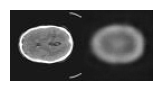

Validation: |                                                                                                 …

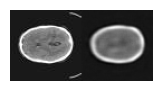

Validation: |                                                                                                 …

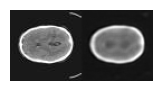

Validation: |                                                                                                 …

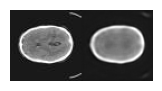

Validation: |                                                                                                 …

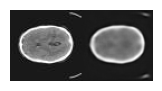

Validation: |                                                                                                 …

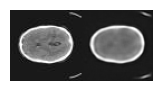

Validation: |                                                                                                 …

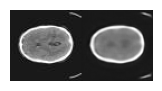

`Trainer.fit` stopped: `max_epochs=75` reached.


In [10]:
max_epochs = 75
val_interval = 10


# initialise the LightningModule
ae_net = AutoEncoder()

# set up checkpoints

checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model")


# initialise Lightning's trainer.
trainer = pl.Trainer(
    devices=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=val_interval,
    num_sanity_val_steps=0,
    callbacks=checkpoint_callback,
    default_root_dir=root_dir,
)

# train
trainer.fit(ae_net)

## Rescaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) became crucial in image-to-image translation models (such as the ones used for super-resolution). For this reason, we will compute the component-wise standard deviation to be used as scaling factor.

In [11]:
def get_scale_factor():
    ae_net.eval()
    device = torch.device("cuda:0")
    ae_net.to(device)

    train_loader = ae_net.train_dataloader()
    check_data = first(train_loader)
    z = ae_net.autoencoderkl.encode_stage_2_inputs(check_data["image"].to(ae_net.device))
    print(f"Scaling factor set to {1/torch.std(z)}")
    scale_factor = 1 / torch.std(z)
    return scale_factor


scale_factor = get_scale_factor()

Scaling factor set to 0.6885251998901367


## Define the LightningModule for DiffusionModelUnet (transforms, network, loaders, etc)

The LightningModule contains a refactoring of your training code. The following module is a reformating of the code in 2d_stable_diffusion_v2_super_resolution.

In [22]:
class DiffusionUNET(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.data_dir = root_dir
        self.unet = DiffusionModelUNet(
            spatial_dims=2,
            in_channels=4,
            out_channels=3,
            num_res_blocks=2,
            channels=(256, 256, 512, 1024),
            attention_levels=(False, False, True, True),
            num_head_channels=(0, 0, 64, 64),
        )
        self.max_noise_level = 350
        self.scheduler = DDPMScheduler(
            num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195
        )
        self.z = ae_net.autoencoderkl.eval()

    def forward(self, x, timesteps, low_res_timesteps):
        return self.unet(x=x, timesteps=timesteps, class_labels=low_res_timesteps)

    def prepare_data(self):
        self.train_ds, self.val_ds = get_datasets()

    def train_dataloader(self):
        return ThreadDataLoader(self.train_ds, batch_size=16, shuffle=True, num_workers=4, persistent_workers=True)

    def val_dataloader(self):
        return ThreadDataLoader(self.val_ds, batch_size=16, shuffle=False, num_workers=4)

    def _calculate_loss(self, batch, batch_idx, plt_image=False):
        images = batch["image"]
        low_res_image = batch["low_res_image"]
        with autocast("cuda", enabled=True):
            with torch.no_grad():
                latent = self.z.encode_stage_2_inputs(images) * scale_factor

            # Noise augmentation
            noise = torch.randn_like(latent)
            low_res_noise = torch.randn_like(low_res_image)
            timesteps = torch.randint(
                0, self.scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device
            ).long()
            low_res_timesteps = torch.randint(
                0, self.max_noise_level, (low_res_image.shape[0],), device=latent.device
            ).long()

            noisy_latent = self.scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
            noisy_low_res_image = self.scheduler.add_noise(
                original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
            )

            latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)

            noise_pred = self.forward(latent_model_input, timesteps, low_res_timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        if plt_image:
            # Sampling image during training
            sampling_image = low_res_image[0].unsqueeze(0)
            latents = torch.randn((1, 3, 16, 16)).to(sampling_image.device)
            low_res_noise = torch.randn((1, 1, 16, 16)).to(sampling_image.device)
            noise_level = 20
            noise_level = torch.Tensor((noise_level,)).long().to(sampling_image.device)

            noisy_low_res_image = self.scheduler.add_noise(
                original_samples=sampling_image,
                noise=low_res_noise,
                timesteps=noise_level,
            )
            self.scheduler.set_timesteps(num_inference_steps=1000)
            for t in tqdm(self.scheduler.timesteps, ncols=110):
                with autocast("cuda", enabled=True):
                    with torch.no_grad():
                        latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
                        noise_pred = self.forward(
                            latent_model_input, torch.Tensor((t,)).to(sampling_image.device), noise_level
                        )
                    latents, _ = self.scheduler.step(noise_pred, t, latents)
            with torch.no_grad():
                decoded = self.z.decode_stage_2_outputs(latents / scale_factor)
            low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
            # plot images

            self.images = images
            self.low_res_bicubic = low_res_bicubic
            self.decoded = decoded

        return loss

    def _plot_image(self, images, low_res_bicubic, decoded):
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(
            torch.cat([images[0, 0].cpu(), low_res_bicubic[0, 0].cpu(), decoded[0, 0].cpu()], dim=1),
            vmin=0,
            vmax=1,
            cmap="gray",
        )
        plt.tight_layout()
        plt.axis("off")
        plt.show()

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, batch_idx)
        self.log("train_loss", loss, batch_size=16, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, batch_idx, plt_image=True)
        self.log("val_loss", loss, batch_size=16, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self._plot_image(self.images, self.low_res_bicubic, self.decoded)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.unet.parameters(), lr=5e-5)
        return optimizer

## Train Diffusion Model

In order to train the diffusion model to perform super-resolution, we will need to **concatenate the latent representation of the high-resolution with the low-resolution image**. Therefore, the number of input channels to the diffusion model will be the sum of the number of channels in the low-resolution (1) and the number of channels of the high-resolution image latent representation (3). In this case,  we create a Diffusion model with `in_channels=4`. Since only the output latent representation is interesting, we set `out_channels=3`. 

**At inference time** we do not have a high-resolution image. Instead, we pass the concatenation of the low resolution image, and noise of the same shape as the latent space representation.

As mentioned, we will use the conditioned augmentation (introduced in [2] section 3 and used on Stable Diffusion Upscalers and Imagen Video [3] Section 2.5) as it has been shown critical for cascaded diffusion models, as well for super-resolution tasks. For this, we apply Gaussian noise augmentation to the low-resolution images. We will use a scheduler low_res_scheduler to add this noise, with the t step defining the signal-to-noise ratio and use the t value to condition the diffusion model (inputted using class_labels argument).

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 1451.62it/s]

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 784.55it/s]
/home/vf19/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /tmp/tmpkazhiy23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | 

Training: |                                                                                                   …

Validation: |                                                                                                 …

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

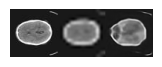

Validation: |                                                                                                 …

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

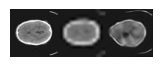

Validation: |                                                                                                 …

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

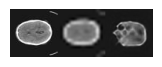

Validation: |                                                                                                 …

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

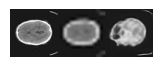

`Trainer.fit` stopped: `max_epochs=200` reached.


In [25]:
max_epochs = 200
val_interval = 50


# initialise the LightningModule
d_net = DiffusionUNET()

# set up checkpoints

checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model_dunet")


# initialise Lightning's trainer.
trainer = pl.Trainer(
    devices=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=val_interval,
    num_sanity_val_steps=0,
    callbacks=checkpoint_callback,
    default_root_dir=root_dir,
)

# train
trainer.fit(d_net)

### Plotting sampling example

As mentioned above, at inference time, we only need to pass noise of the same shape of the latent concatenated to the low-resolution image, to get the latent representation of the corresponding high-resolution image.

In [26]:
num_samples = 3


def get_images_to_plot():
    d_net.eval()
    device = torch.device("cuda:0")
    d_net.to(device)

    val_loader = d_net.val_dataloader()
    check_data = first(val_loader)
    images = check_data["image"].to(d_net.device)

    sampling_image = check_data["low_res_image"][:num_samples].to(d_net.device)
    latents = torch.randn((num_samples, 3, 16, 16)).to(d_net.device)
    low_res_noise = torch.randn((num_samples, 1, 16, 16)).to(d_net.device)
    noise_level = 10
    noise_level = torch.Tensor((noise_level,)).long().to(d_net.device)
    scheduler = d_net.scheduler
    noisy_low_res_image = scheduler.add_noise(
        original_samples=sampling_image, noise=low_res_noise, timesteps=torch.Tensor((noise_level,)).long()
    )

    scheduler.set_timesteps(num_inference_steps=1000)
    for t in tqdm(scheduler.timesteps, ncols=110):
        with autocast("cuda", enabled=True):
            with torch.no_grad():
                latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
                noise_pred = d_net.forward(
                    x=latent_model_input, timesteps=torch.Tensor((t,)).to(d_net.device), low_res_timesteps=noise_level
                )
            # 2. compute previous image: x_t -> x_t-1
            latents, _ = scheduler.step(noise_pred, t, latents)

    with torch.no_grad():
        decoded = ae_net.autoencoderkl.decode_stage_2_outputs(latents / scale_factor)
    return sampling_image, images, decoded


sampling_image, images, decoded = get_images_to_plot()

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]

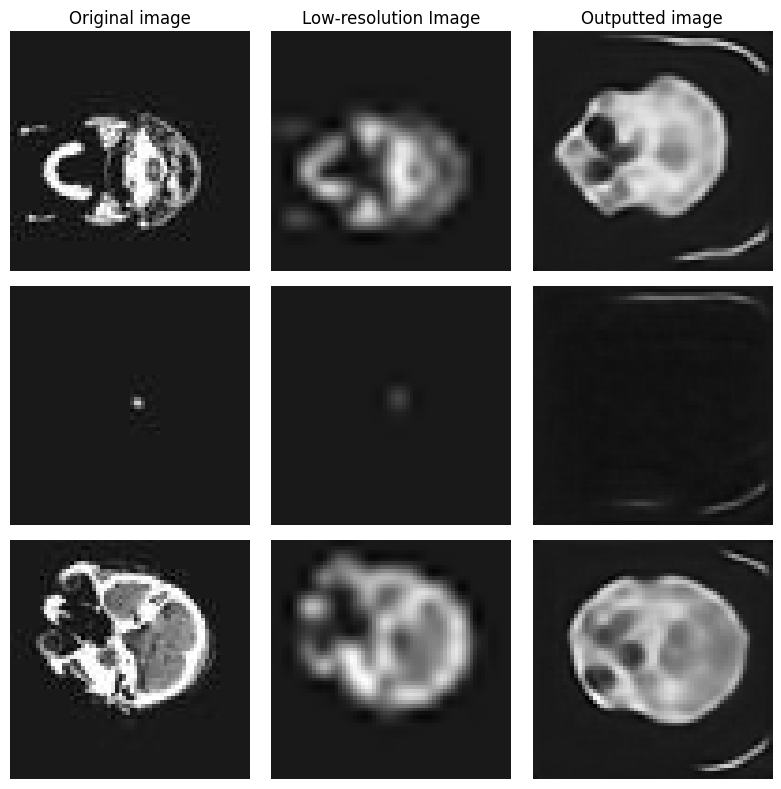

In [27]:
low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
fig, axs = plt.subplots(num_samples, 3, figsize=(8, 8))
axs[0, 0].set_title("Original image")
axs[0, 1].set_title("Low-resolution Image")
axs[0, 2].set_title("Outputted image")
for i in range(0, num_samples):
    axs[i, 0].imshow(images[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(low_res_bicubic[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(decoded[i, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
    axs[i, 2].axis("off")
plt.tight_layout()

### Clean-up data directory

In [15]:
if directory is None:
    shutil.rmtree(root_dir)